In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
N = 200
my_range = [0, 10]
power = 2
delta = (my_range[1]-my_range[0])/(N-1)
x = np.arange(my_range[0], my_range[1]+delta, delta)
f = lambda x: 3*np.sin(5*x)+x

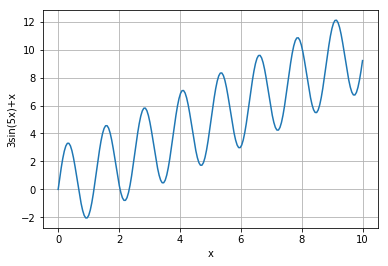

In [3]:
def print_plot(x, y):
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('3sin(5x)+x')
    plt.grid(True)
    plt.show()

print_plot(x, f(x))

In [4]:
import tensorflow as tf
# import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras import optimizers
from keras import losses
from keras.callbacks import EarlyStopping
from keras import backend as K

Using TensorFlow backend.


learn len: 120


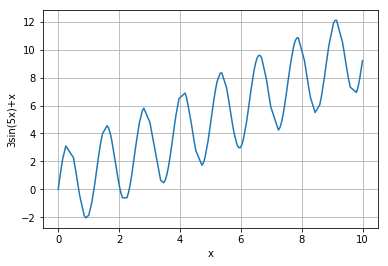

valid len: 60


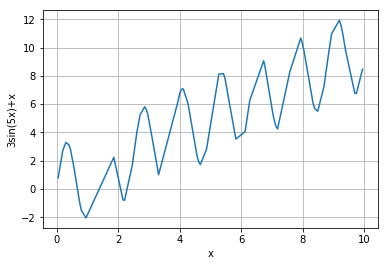

test len: 20


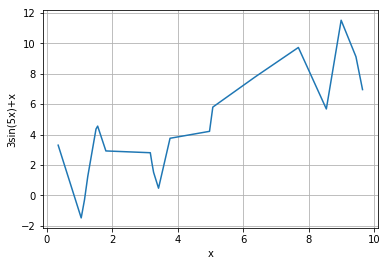

In [5]:
def build_dataset(x, func, learn_p=0.6, valid_p=0.3, test_p=0.1):
    x_set = set(x)
    def subsample(x, x_rest, func, p):
        data = np.random.permutation(list(x_rest))[:int(len(x)*p)]
        x_rest -= set(data)
        return {'data': data, 'true': func(data)}
    learn = subsample(x, x_set, func, learn_p)
    valid = subsample(x, x_set, func, valid_p)
    test = subsample(x, x_set, func, test_p)
    return learn, valid, test

def sort_data(data):
    s = sorted(zip(data['data'], data['true']), key=lambda x: x[0])
    return [i[0] for i in s], [i[1] for i in s]
    
        
learn, valid, test = build_dataset(x, f)
print('learn len:', len(learn['data']))
print_plot(*(sort_data(learn)))
print('valid len:', len(valid['data']))
print_plot(*(sort_data(valid)))
print('test len:', len(test['data']))
print_plot(*(sort_data(test)))

In [6]:
def rows_in_power_below(array, min_dim, max_dim):
    return np.vstack([np.power(array, i) for i in range(min_dim, max_dim + 1)])

x_transformed = {'data': x, 'true': f(x)}

for sample in (learn, valid, test, x_transformed):
    sample['data'] = rows_in_power_below(sample['data'], 0, power).transpose()
    print(np.shape(sample['data']))

(120, 3)
(60, 3)
(20, 3)
(200, 3)


In [7]:
from keras.callbacks import Callback 
def plot_all(model):
    f = K.function([model.layers[0].input], [model.layers[0].output])
    fig, ax = plt.subplots()
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.plot(x, f([x_transformed['data']])[0])
    ax.legend()
    plt.show()
    
class TestGraph(Callback): 
    def __init__(self, test): 
        self.test = test

    def on_train_begin(self, logs={}): 
        self.test_loss = [] 
        self.test_acc = [] 

    def on_epoch_end(self, batch, logs={}): 
        loss, acc = self.model.evaluate(self.test['data'], self.test['true'], verbose=0) 
        self.test_loss.append(loss) 
        self.test_acc.append(1 - acc)

3


No handles with labels found to put in legend.


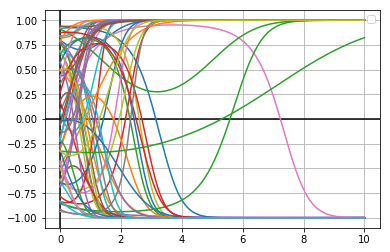

633.171875


In [29]:
approx = Sequential()
dim = np.shape(learn['data'])[1]
count = 60
epochs = 60_000
print(dim)

class Weights(Callback): 
    def on_train_begin(self, logs={}): 
        self.hidden_weights = [] 
        self.output_weights = [] 

    def on_epoch_end(self, batch, logs={}): 
        weights = self.model.layers[0].get_weights()[0] 
        bias = self.model.layers[0].get_weights()[1].reshape(1, -1) 
        hid_weights = np.concatenate([bias, weights], axis=0) 
        self.hidden_weights.append(hid_weights.flatten()) 

        weights = self.model.layers[1].get_weights()[0] 
        bias = self.model.layers[1].get_weights()[1].reshape(1, -1) 
        out_weights = np.concatenate([bias, weights], axis=0) 
        self.output_weights.append(out_weights.flatten()) 

approx.add(Dense(count, activation='tanh', input_dim=dim, kernel_initializer='he_normal'))
approx.add(Dense(1))
opti = optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
approx.compile(loss= 'mean_squared_error', optimizer=opti, metrics=['accuracy'])

approx.build()

f_predict_before = approx.predict(x_transformed['data'], batch_size=None, verbose=0, steps=None)
plot_all(approx)
stop = EarlyStopping(monitor='val_loss', min_delta=0.000_001, patience=25_000, verbose=0, restore_best_weights=False)
weight = Weights()
test_graph = TestGraph(test)
t1 = time.process_time()
history = approx.fit(
    learn['data'], learn['true'], batch_size=20, epochs=epochs, callbacks=[stop, weight, test_graph],
    verbose=0, validation_data=(valid['data'], valid['true']), shuffle=False
)
print(time.process_time() - t1)

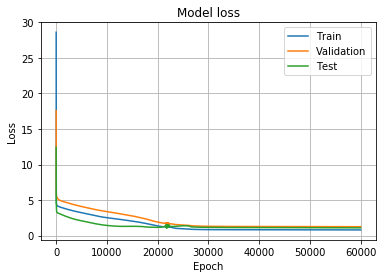

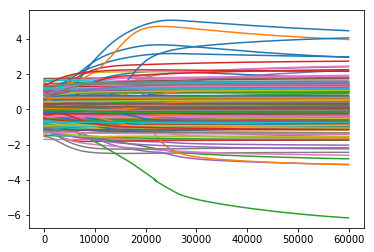

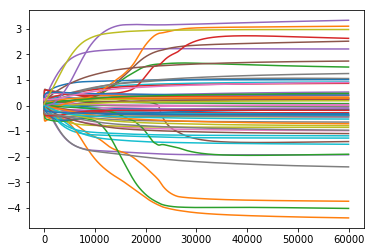

No handles with labels found to put in legend.


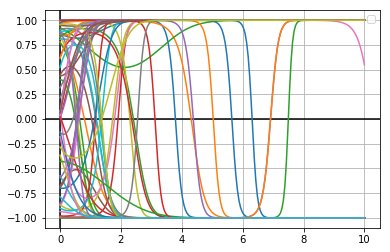

In [30]:
def show_loss(history, test_graph):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(test_graph.test_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper right')
    plt.grid(True)
    plt.show()
    
def show_weight(weight):
    plt.plot(weight)
    plt.show()
    

show_loss(history, test_graph)
show_weight(weight.hidden_weights)
show_weight(weight.output_weights)
plot_all(approx)

In [31]:
score = approx.evaluate(valid['data'], valid['true'],verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

60/60 [==============================] - 0s 33us/step
Test score: 1.257612903912862
Test accuracy: 0.0


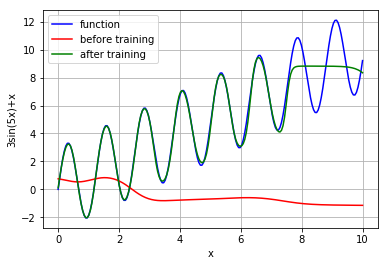

In [32]:
f_predict = approx.predict(x_transformed['data'], batch_size=None, verbose=0, steps=None)
plt.plot(x, f(x), 'b')
plt.plot(x, f_predict_before, 'r')
plt.plot(x, f_predict, 'g')
plt.xlabel('x')
plt.ylabel('3sin(5x)+x')
plt.grid(True)
plt.legend(['function', 'before training', 'after training'], loc='upper left')
plt.show()

In [33]:
def errors(sample):
    predict = approx.predict(sample['data'], verbose=0, steps=None)
    mse, _ = approx.evaluate(sample['data'], sample['true'],verbose=0)
    error = [y - yp for y, yp in zip(sample['true'], predict)]
    print(f'max_abs_error: {max(abs(e) for e in error)[0]:.4}')
    print(f'std: {np.std(error):.4}')
    print(f'rmse: {mse ** 0.5:.4}')
    print(f'{max(abs(e) for e in error)[0]:.4},')
    
errors(learn)
print('============== learn')
errors(valid)
print('============== valid')
errors(test)
print('============== test')

max_abs_error: 3.315
std: 0.8988
rmse: 0.9011
3.315,
============== learn
max_abs_error: 3.321
std: 1.12
rmse: 1.121
3.321,
============== valid
max_abs_error: 3.138
std: 1.049
rmse: 1.049
3.138,
============== test
